<a href="https://colab.research.google.com/github/cyFou/testColab/blob/main/AnyDepht_PointOfCloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source du tuto
https://levelup.gitconnected.com/building-a-perfect-million-parameter-llm-like-chatgpt-in-python-3b16e26b4139


In [ ]:
#source de ce test : https://medium.com/data-science-collective/depthanything-v2-tutorial-how-to-convert-2d-images-to-3d-models-with-python-2708d295b7e5

In [3]:
# Install Open3D for point cloud and mesh processing
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.6 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [4]:
import os
import random
from pathlib import Path
import requests

import numpy as np
import matplotlib.pyplot as plt
import cv2

import open3d as o3d
from mpl_toolkits import mplot3d

import torch

In [ ]:


from transformers import AutoImageProcessor, AutoModelForDepthEstimation

#Step 2: Preparing Your Image Data

# Download the image from the URL
# image_url = ["https://www.lemoniteur.fr/mediatheque/9/2/0/001921029_896x598_c.jpg",
#              "https://www.index-assurance.fr/fichiers/images/peugeot-208-allure.jpg"]


image_url = ["https://www.camif-habitat.fr/wp-content/uploads/data/2021/11/23738/amenagement-espace.jpg",
             "https://www.depreux-construction.com/wp-content/uploads/2019/08/agencement-interieur-construction-maison.jpg"]


def rescale_by_width(image, target_width, method=cv2.INTER_LANCZOS4):
    """Rescale `image` to `target_width` (preserving aspect ratio)."""
    h = int(round(target_width * image.shape[0] / image.shape[1]))
    return cv2.resize(image, (target_width, h), interpolation=method)

liste_image = []
for img in image_url:
  response = requests.get(img)
  image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
  selected_image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
  selected_image = cv2.cvtColor(selected_image, cv2.COLOR_BGR2RGB)
  liste_image.append(rescale_by_width(selected_image,300))

In [ ]:
import plotly.graph_objects as go
def Scatter3d(pcd_aff):
  points = np.asarray(pcd_aff.points)
  colors = np.asarray(pcd_aff.colors)
  fig = go.Figure(
      data=[
          go.Scatter3d(
              x=points[:,0], y=points[:,1], z=points[:,2],
              mode='markers',
              marker=dict(size=1, color=colors)
          )
      ],
      layout=dict(
          scene=dict(
              xaxis=dict(visible=False),
              yaxis=dict(visible=False),
              zaxis=dict(visible=False)
          )
      )
  )
  fig.show()

In [ ]:
def draw_geometries(geometries):
    graph_objects = []
    axis = o3d.geometry.TriangleMesh.create_coordinate_frame(size=30,origin=geometries[0].get_center())
    geometries.append(axis)
    for geometry in geometries:
        geometry_type = geometry.get_geometry_type()

        if geometry_type == o3d.geometry.Geometry.Type.PointCloud:
            points = np.asarray(geometry.points)
            colors = None
            if geometry.has_colors():
                colors = np.asarray(geometry.colors)
            elif geometry.has_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
            else:
                geometry.paint_uniform_color((1.0, 0.0, 0.0))
                colors = np.asarray(geometry.colors)

            scatter_3d = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=1, color=colors))
            graph_objects.append(scatter_3d)

        if geometry_type == o3d.geometry.Geometry.Type.TriangleMesh:
            triangles = np.asarray(geometry.triangles)
            vertices = np.asarray(geometry.vertices)
            colors = None
            if geometry.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                colors = (1.0, 0.0, 0.0)

            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)

    fig = go.Figure(
        data=graph_objects,
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()

In [ ]:

#Step 3: Understanding and Loading Depth Anything v2
checkpoints = [
    "Intel/zoedepth-nyu-kitti",
    "LiheYoung/depth-anything-large-hf",
    "jingheya/lotus-depth-g-v1-0",
    "tencent/DepthCrafter"
    ]

checkpoint = checkpoints[1]
device = "cpu"
# take care of the necessary image transformations such as resizing and normalization
processor = AutoImageProcessor.from_pretrained(checkpoints[1])
model = AutoModelForDepthEstimation.from_pretrained(checkpoints[1]).to(device)

#Step 4: Processing Images for Depth Estimation
num_samples = 2
depth_samples = []
for i in range(num_samples):
    depth_input = processor(images=liste_image[i], return_tensors="pt").to(device)

    # Infer model
    with torch.no_grad():
        inference_outputs = model(**depth_input)
        output_depth = inference_outputs.predicted_depth

    output_depth = output_depth.squeeze().cpu().numpy()

    #pour affiner la depth_image si besoin, en prservant les angles saillant
    #cv2.bilateralFilter(depth_image, 5, 75, 75)

    depth_samples.append([liste_image[i], output_depth])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

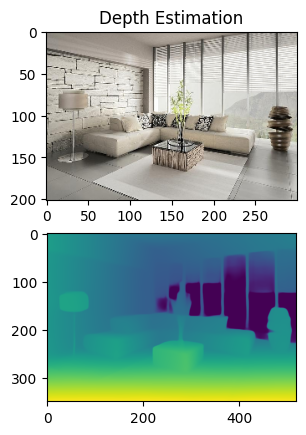

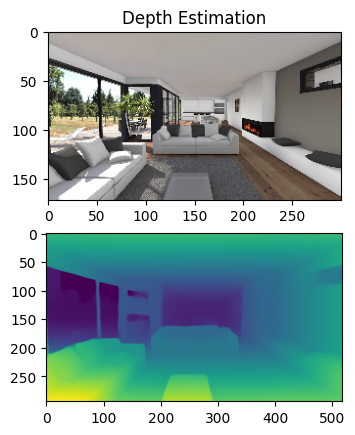

In [ ]:
#Step 5: Visualizing Depth Maps
#plt.rcParams['figure.dpi'] = 100

for i in range(num_samples):
    fig, axs = plt.subplots(2, 1)

    axs[0].imshow(depth_samples[i][0])
    axs[0].set_title('Depth Estimation')
    axs[1].imshow(depth_samples[i][1])

    plt.show()

In [35]:
def depth_to_pointcloud(depth_image, color_image, scale_factor=255):
  #Step 6: Generating 3D Point Clouds with the Pinhole Method
  i = 0

  width, height = depth_image.shape

  depth_image = (depth_image * 255 / np.max(depth_image)).astype('uint8')
  color_image = cv2.resize(color_image, (height, width))


  depth_o3d = o3d.geometry.Image(depth_image)
  image_o3d = o3d.geometry.Image(color_image)
  rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(image_o3d, depth_o3d, convert_rgb_to_intensity=False)

  camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()

  # If focal length is too small: Objects appear "stretched" in depth
  # If focal length is too large: Objects appear "compressed" in depth

  # to create metrically accurate 3D reconstructions that match real-world scale:
  fx = fy = width * 0.8  # A good approximation for a standard lens
  cx, cy = width/2, height/2  # Center of the image

  camera_intrinsic.set_intrinsics(width, height, fx, fy, cx, cy)

  pcd_raw = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)

  # outliers removal
  cl, ind = pcd_raw.remove_statistical_outlier(nb_neighbors=20, std_ratio=1.0)
  pcd = pcd_raw.select_by_index(ind)
  return pcd

  # #reduire la résolution
  # pcd.voxel_down_sample(voxel_size=0.01)

  # # estimate normals
  # pcd.estimate_normals()
  # pcd.orient_normals_to_align_with_direction()



# depth_image = depth_samples[i][1]
# color_image = depth_samples[i][0]

# pcd_aff = depth_to_pointcloud(depth_image,color_image)
#o3d.visualization.draw_geometries([pcd_raw])

In [ ]:
!wget https://raw.githubusercontent.com/PointCloudLibrary/pcl/master/test/bunny.pcd
pcd_raw = o3d.io.read_point_cloud("bunny.pcd")
if pcd_raw.is_empty(): exit()
pcd_raw.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))


--2025-08-20 14:33:29--  https://raw.githubusercontent.com/PointCloudLibrary/pcl/master/test/bunny.pcd
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10878 (11K) [text/plain]
Saving to: ‘bunny.pcd.2’

bunny.pcd.2         100%[===================>]  10.62K  --.-KB/s    in 0.001s  

2025-08-20 14:33:30 (8.25 MB/s) - ‘bunny.pcd.2’ saved [10878/10878]



<function matplotlib.pyplot.show(close=None, block=None)>

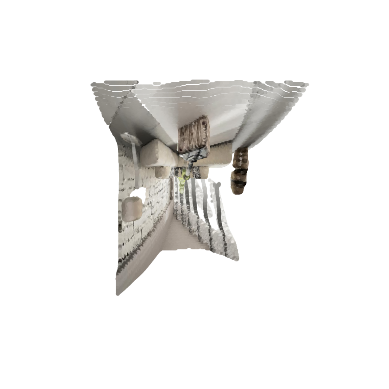

In [ ]:

points = np.asarray(pcd_aff.points)

colors = None
if pcd_aff.has_colors():
    colors = np.asarray(pcd_aff.colors)
elif pcd_aff.has_normals():
    colors = (0.5, 0.5, 0.5) + np.asarray(pcd_aff.normals) * 0.5
# else:
#     geometry.paint_uniform_color((1.0, 0.0, 0.0))
#     colors = np.asarray(geometry.colors)
# Single View
ax = plt.axes(projection='3d')
ax.view_init(90, -90)
ax.axis("off")
ax.scatter(points[:,0], points[:,1], points[:,2], s=1, c=colors)
#plt.rcParams['figure.dpi'] = 200
plt.show


In [ ]:
# Scatter3d(pcd_aff)
draw_geometries([pcd_aff])

In [ ]:
#Step 8: Creating Point Clouds with Orthographic Projection
def depth_to_pointcloud_orthographic(depth_map, image, scale_factor=255):

    height, width = depth_map.shape

    # Create a grid of pixel coordinates
    y, x = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')

    # Scale the depth values
    z = (depth_map / scale_factor) * height/2

    # Create 3D points (x and y are pixel coordinates, z is from the depth map)
    points = np.stack((x, y, z), axis=-1).reshape(-1, 3)

    # Filter out points with zero depth
    mask = points[:, 2] != 0
    points = points[mask]

    # Create Open3D PointCloud object
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    #o3d.visualization.draw_geometries([pcd])

    # Add colors to the point cloud
    colors = image.reshape(-1, 3)[mask] / 255.0  # Normalize color values to [0, 1]
    pcd.colors = o3d.utility.Vector3dVector(colors)

    _, ind = pcd.remove_statistical_outlier(nb_neighbors=15, std_ratio=1)
    inlier_cloud = pcd.select_by_index(ind)

    return inlier_cloud, z, height, width

In [ ]:
# Convert depth map and image to point cloud
point_cloud, z, height, width  = depth_to_pointcloud_orthographic(depth_image, color_image)
#Scatter3d(point_cloud)
draw_geometries([point_cloud])


In [ ]:
point_cloud.estimate_normals()
point_cloud.orient_normals_to_align_with_direction()

print('run Poisson surface reconstruction')
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(point_cloud, depth=9)
draw_geometries([mesh])

In [ ]:
!git clone https://github.com/facebookresearch/vggt.git
#!pip install -r vggt/requirements.txt
import sys
sys.path.append('vggt')


fatal: destination path 'vggt' already exists and is not an empty directory.


In [ ]:
from pprint import pp
pp(sys.path)

['/content',
 '/env/python',
 '/usr/lib/python312.zip',
 '/usr/lib/python3.12',
 '/usr/lib/python3.12/lib-dynload',
 '',
 '/usr/local/lib/python3.12/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.12/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content',
 '/vggt']


In [ ]:
import torch
import requests
from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images

device = "cuda" if torch.cuda.is_available() else "cpu"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+)
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

# Initialize the model and load the pretrained weights.
# This will automatically download the model weights the first time it's run, which may take a while.
model = VGGT.from_pretrained("facebook/VGGT-1B").to(device)




In [ ]:
import cv2
import numpy as np

image_url = ["https://www.camif-habitat.fr/wp-content/uploads/data/2021/11/23738/amenagement-espace.jpg",
             "https://www.depreux-construction.com/wp-content/uploads/2019/08/agencement-interieur-construction-maison.jpg"]
i=0
for img in image_url:
  img_data = requests.get("https://www.camif-habitat.fr/wp-content/uploads/data/2021/11/23738/amenagement-espace.jpg").content
  with open(str(i)+'.jpg', 'wb') as handler:
    handler.write(img_data)
  i=i+1

#autre exemple avec PIL
# from PIL import Image
# import requests
# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)

In [ ]:
# Load and preprocess example images (replace with your own image paths)
image_names = ["0jpg"]
images = load_and_preprocess_images(image_names).to(device)

with torch.no_grad():
    with torch.cuda.amp.autocast(dtype=dtype):
        # Predict attributes including cameras, depth maps, and point maps.
        predictions = model(images)

In [ ]:
from vggt.utils.pose_enc import pose_encoding_to_extri_intri
from vggt.utils.geometry import unproject_depth_map_to_point_map

with torch.no_grad():
    with torch.cuda.amp.autocast(dtype=dtype):
        images = images[None]  # add batch dimension
        aggregated_tokens_list, ps_idx = model.aggregator(images)

    # Predict Cameras
    pose_enc = model.camera_head(aggregated_tokens_list)[-1]
    # Extrinsic and intrinsic matrices, following OpenCV convention (camera from world)
    extrinsic, intrinsic = pose_encoding_to_extri_intri(pose_enc, images.shape[-2:])

    # Predict Depth Maps
    depth_map, depth_conf = model.depth_head(aggregated_tokens_list, images, ps_idx)

    # Predict Point Maps
    point_map, point_conf = model.point_head(aggregated_tokens_list, images, ps_idx)

    # Construct 3D Points from Depth Maps and Cameras
    # which usually leads to more accurate 3D points than point map branch
    point_map_by_unprojection = unproject_depth_map_to_point_map(depth_map.squeeze(0),
                                                                extrinsic.squeeze(0),
                                                                intrinsic.squeeze(0))

    # Predict Tracks
    # choose your own points to track, with shape (N, 2) for one scene
    query_points = torch.FloatTensor([[100.0, 200.0],
                                        [60.72, 259.94]]).to(device)
    track_list, vis_score, conf_score = model.track_head(aggregated_tokens_list, images, ps_idx, query_points=query_points[None])


In [ ]:
print(point_map_by_unprojection.shape)
#point 3D(1, 350, 518, 3)

(1, 350, 518, 3)


In [7]:
!pip install transformers

In [2]:
from transformers import GLPNImageProcessor, GLPNForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests


In [5]:

url = "https://www.camif-habitat.fr/wp-content/uploads/data/2021/11/23738/amenagement-espace.jpg"
image = Image.open(requests.get(url, stream=True).raw)

processor = GLPNImageProcessor.from_pretrained("vinvino02/glpn-nyu")
model = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-nyu")

# prepare image for the model
inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/245M [00:00<?, ?B/s]

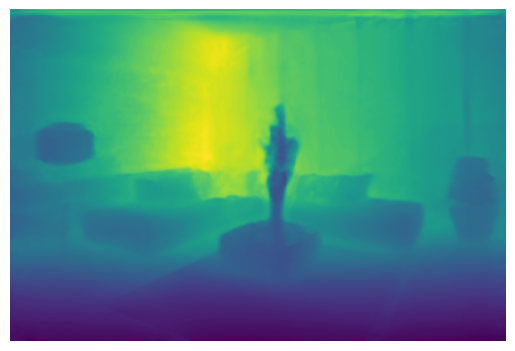

In [6]:
import matplotlib.pyplot as plt

plt.imshow(depth)
plt.axis('off')
plt.show()

In [37]:
#print(np.array(depth).unsqueeze().shape)
print(prediction.squeeze().cpu().numpy().shape)

(442, 661)


In [38]:
# Convert depth map and image to point cloud
image = inputs.pixel_values.squeeze(0).permute(2,1,0).cpu().numpy()
point_cloud = depth_to_pointcloud(prediction.squeeze().cpu().numpy(), image)
#Scatter3d(point_cloud)
draw_geometries([point_cloud])

RuntimeError: [1;31m[Open3D Error] (static std::shared_ptr<open3d::geometry::PointCloud> open3d::geometry::PointCloud::CreateFromRGBDImage(const open3d::geometry::RGBDImage&, const open3d::camera::PinholeCameraIntrinsic&, const Matrix4d&, bool)) /root/Open3D/cpp/open3d/geometry/PointCloudFactory.cpp:176: Unsupported image format.
[0;m

In [13]:
print(inputs.pixel_values.shape)



torch.Size([1, 3, 416, 640])
(640, 416, 3)
[[[0.5411765  0.52156866 0.49803922]
  [0.53333336 0.5137255  0.49019608]
  [0.5254902  0.5058824  0.48235294]
  ...
  [0.5137255  0.50980395 0.49019608]
  [0.50980395 0.5058824  0.4862745 ]
  [0.50980395 0.5058824  0.4862745 ]]

 [[0.5411765  0.52156866 0.49803922]
  [0.53333336 0.5137255  0.49019608]
  [0.5294118  0.50980395 0.4862745 ]
  ...
  [0.5137255  0.50980395 0.49019608]
  [0.5058824  0.5019608  0.48235294]
  [0.5058824  0.5019608  0.48235294]]

 [[0.54509807 0.5254902  0.5019608 ]
  [0.5372549  0.5176471  0.49411765]
  [0.5294118  0.50980395 0.4862745 ]
  ...
  [0.5137255  0.50980395 0.49019608]
  [0.5058824  0.5019608  0.48235294]
  [0.5058824  0.5019608  0.48235294]]

 ...

 [[0.6862745  0.6745098  0.64705884]
  [0.56078434 0.54901963 0.52156866]
  [0.7176471  0.7058824  0.6784314 ]
  ...
  [0.7372549  0.7411765  0.72156864]
  [0.7411765  0.74509805 0.7254902 ]
  [0.7411765  0.74509805 0.7254902 ]]

 [[0.68235296 0.67058825 0.6431